In [3]:
import numpy as np
import matplotlib.pyplot as plt

import json
import nltk

from pathlib import Path

In [15]:
data_path = Path("conversation_data/")
query_convos = data_path / "queries_convos.jsonl"
prd_convos = data_path / "prd_convos.jsonl"
tone_aug_convos = data_path / "tone_aug_convos.jsonl"
colloquial_convos = data_path / "colloquial_convos.jsonl"
non_native_convos = data_path / "non_native_convos.jsonl"
typo_convos = data_path / "typo_convos.jsonl"

convo_paths = [query_convos, prd_convos, tone_aug_convos, colloquial_convos, non_native_convos, typo_convos]

In [3]:
OUTLIER_THRESHOLD: int = 30

# Outlier Conversations

Here, we check for conversations whose length exceed the threshold value.
Looking at these conversations, we see that the cause for this is that the agent strictly checks for "RESOLVED" or "UNRESOLVED" as the termination condition. And in these cases, the customer agent is outputting "resolved" which fails to trigger the termination condition. However, we see that this bug is not impacting our dataset much since the number of outlier conversations is trivial relative to the dataset size.

In [4]:
def get_outliers(file_name: Path, threshold: int = OUTLIER_THRESHOLD) -> list[dict]:
    """Returns the outlier conversations in a conversation file."""
    len_stats = []
    outliers = []
    for line in open(file_name, 'r'):
        convo = json.loads(line)
        length = convo["length"]
        if length > threshold:
            outliers.append(convo["conversation"])
    return outliers

In [5]:
len(get_outliers(query_convos, OUTLIER_THRESHOLD)[1])

101

In [6]:
outlier_len = []
for convo_file in convo_paths:
    outliers = get_outliers(convo_file, 30)
    for o in outliers:
        outlier_len.append(len(o))

Text(0, 0.5, 'Frequency')

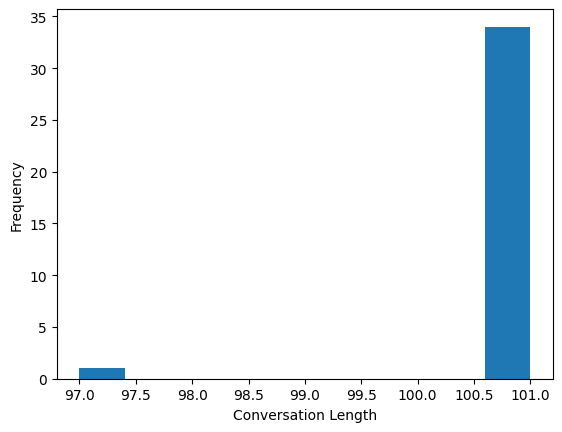

In [7]:
plt.hist(outlier_len);
plt.xlabel("Conversation Length")
plt.ylabel("Frequency")

In [8]:
len(outlier_len)

35

We see that the total number of outliers is 35 across the dataset of 14,000 conversations.

# Conversation Length Distribution

Here, we first show the conversation length distribution for one conversation file, and then the same analysis across the dataset.

In [9]:
def get_lengths(file_path: Path, consider_outliers: bool = False) -> list[int]:
    """Returns a list of lengths of all conversations in the given file."""
    lengths = []
    for line in open(file_path, 'r'):
        convo = json.loads(line)
        length = convo["length"]
        if not consider_outliers and length > OUTLIER_THRESHOLD:
            continue
        lengths.append(convo["length"])
    return lengths

In [10]:
convo_lengths = []
convo_lengths.extend(
    get_lengths(query_convos)
)

Text(0, 0.5, 'Frequency')

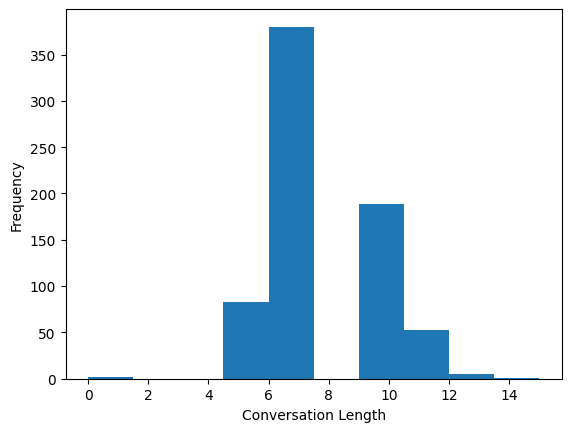

In [11]:
plt.hist(convo_lengths);
plt.xlabel("Conversation Length")
plt.ylabel("Frequency")

In [12]:
convo_lengths = []
for convo_file in convo_paths:
    convo_lengths.extend(
        get_lengths(convo_file)
    )

Text(0, 0.5, 'Frequency')

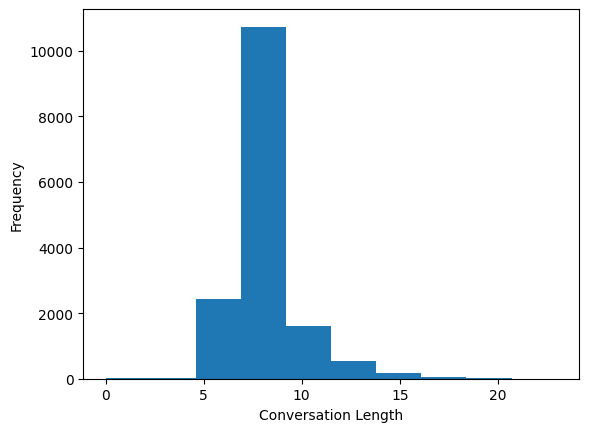

In [13]:
plt.hist(convo_lengths);
plt.xlabel("Conversation Length")
plt.ylabel("Frequency")

In [14]:
np.median(convo_lengths), np.mean(convo_lengths)

(7.0, 7.916393758428049)

We see that the median length of conversations is 7 and mean length 7.9 or ~8.

# Resolution Status Analysis

Here, we analyse the distribution of the resolution status of conversations.

**Background**: The conversations are naturally led to resolve or stay unresolved without any explicit prompting to directly influence the resolution status.

In [15]:
def get_resolution_stat(file_path: Path) -> tuple[int, int]:
    """Returns a tuple containing number of resolved and unresolved conversations respectively."""
    resolved_count = 0
    unresolved_count = 0
    for line in open(file_path, 'r'):
        convo = json.loads(line)
        if convo["status"] == "RESOLVED":
            resolved_count += 1
        else:
            unresolved_count += 1
    return resolved_count, unresolved_count

In [16]:
resolved_percentages = []
for convo_file in convo_paths:
    r, u = get_resolution_stat(convo_file)
    resolved_percentages.append(r/(r+u) * 100)
    print("%25s | Resolved: %4s | Unresolved: %4s | Resolved percentage: %.2f%%" % (\
        str(convo_file).split('/')[-1],
        r,
        u,
        resolved_percentages[-1]
    ))

     queries_convos.jsonl | Resolved:  620 | Unresolved:   95 | Resolved percentage: 86.71%
         prd_convos.jsonl | Resolved:  519 | Unresolved:   69 | Resolved percentage: 88.27%
    tone_aug_convos.jsonl | Resolved: 1599 | Unresolved: 1004 | Resolved percentage: 61.43%
  colloquial_convos.jsonl | Resolved: 3000 | Unresolved:  898 | Resolved percentage: 76.96%
  non_native_convos.jsonl | Resolved: 2583 | Unresolved: 1316 | Resolved percentage: 66.25%
        typo_convos.jsonl | Resolved: 2627 | Unresolved: 1278 | Resolved percentage: 67.27%


In [17]:
np.std(resolved_percentages), np.mean(resolved_percentages)

(10.294748379169206, 74.4817901806634)

From the standard deviation, we see that the resolution percentages deviate by 10% at maximum and have a mean of ~74.48.

# Error Rates

Some LLM calls failed due to lack of a retry mechanism. This little exercise captures that.

In [18]:
def get_num_errors(file_path: Path) -> int:
    """Returns the number of errors in the conversation file."""
    num_errors = 0
    for line in open(file_path, 'r'):
        convo = json.loads(line)
        if convo["status"] == "ERROR":
            num_errors += 1
    return num_errors

In [19]:
num_errors = 0
for convo_file in convo_paths:
    num_errors += get_num_errors(convo_file)

In [20]:
num_errors

29

We have 29 calls across the 14k conversations that have failed which is very tiny in comparison.

## Product Augmentations Analysis

Here, we show the products used for augmentation and also the number of queries having various products.

In [34]:
products = "smartphone, laptop, washing machine, microwave oven, smart watch, camera".split(", ")

In [35]:
def get_counts(product: str, fname: Path):
    count = 0
    for line in open(fname, 'r'):
        convo = json.loads(line)
        if product in str(convo["conversation"]): count += 1
    return count

In [36]:
counts = []
for product in products:
    counts.append(0)
    for convo_file in convo_paths:
        counts[-1] += get_counts(product, convo_file)

In [37]:
counts

[1242, 1319, 1191, 965, 800, 1285]

Text(0, 0.5, 'Frequency')

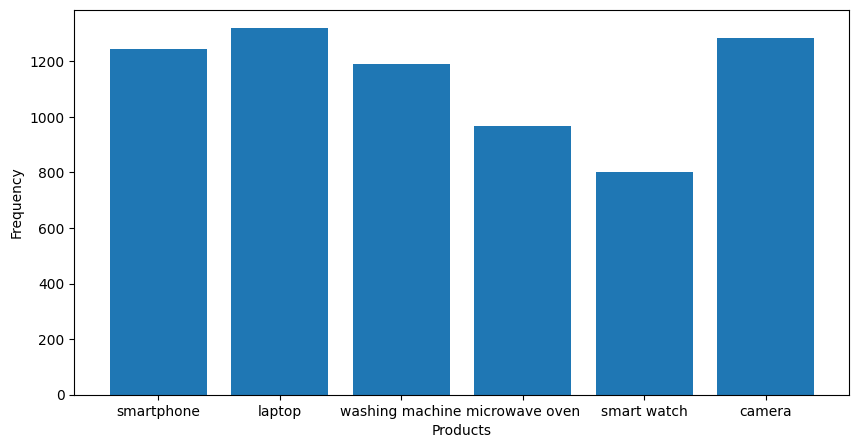

In [48]:
plt.figure(figsize=(10, 5))
plt.bar(products, counts);
plt.xlabel("Products")
plt.ylabel("Frequency")

## Customer Tone Analysis

Here, we show the distribution of customer tones or sentiments across conversations.

In [52]:
tone_count = {"neutral": 0, "cheerful": 0, "annoyed": 0}

In [53]:
for convo_file in convo_paths:
    for line in open(convo_file, 'r'):
        convo = json.loads(line)
        tone_count[convo["tone"]] += 1

In [54]:
tone_count

{'neutral': 5212, 'cheerful': 5192, 'annoyed': 5204}

Text(0, 0.5, 'Frequency')

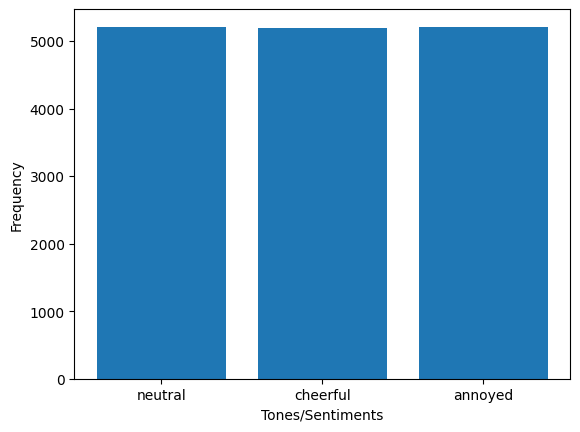

In [57]:
plt.bar(tone_count.keys(), tone_count.values());
plt.xlabel("Tones/Sentiments")
plt.ylabel("Frequency")

## Language Style Analysis

Here, we show the distribution of various language styles we used to augment the data.

In [71]:
style_count = {"regular": 0, "typos": 0, "non_native": 0, "colloquial": 0}

In [72]:
for convo_file in convo_paths:
    for line in open(convo_file, 'r'):
        convo = json.loads(line)
        style_count[convo["style"]] += 1

In [73]:
style_count

{'regular': 3906, 'typos': 3905, 'non_native': 3899, 'colloquial': 3898}

Text(0, 0.5, 'Frequency')

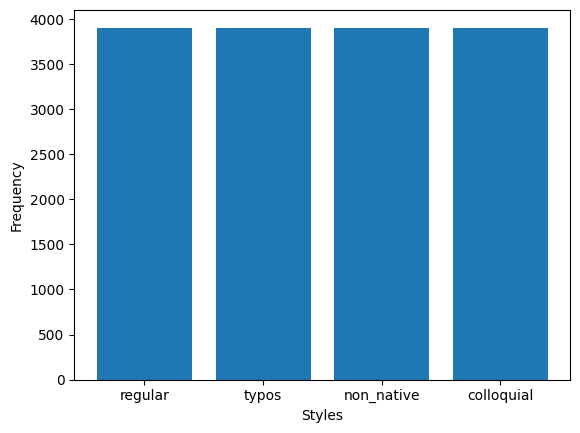

In [76]:
plt.bar(style_count.keys(), style_count.values());
plt.xlabel("Styles")
plt.ylabel("Frequency")